# Visual Covariance Test

$$
% latex macros.  this does not work when converting to latex.
\newcommand{\bm}[1]{\boldsymbol{#1}}
\DeclareMathOperator{\cov}{cov}
\DeclareMathOperator{\diag}{diag}
\newcommand{\ud}{\mathrm{d}}
\newcommand{\XX}{{\bm X}}
\newcommand{\VV}{{\bm V}}
\newcommand{\N}{\mathcal{N}}
\newcommand{\mmu}{{\bm \mu}}
\newcommand{\SSi}{{\bm \Sigma}}
\newcommand{\ssi}{{\bm \sigma}}
$$

Pick a covariance type. Then for $x_t$ and $v_t = \ud x_t/\ud t$, visually check that
$$
\begin{aligned}
\cov(x_t, v_s) & = \int_0^t \cov(v_u, v_s) \, \ud u \\
\cov(x_t, x_s) & = \int_0^t\int_0^s \cov(v_u, v_w) \, \ud u\, \ud w
\end{aligned}
$$
by comparing analytic formula to numerical integration with `scipy.integrate.quad` and `scipy.integrate.dblquad`.

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform as runif
from scipy import integrate
import BayesODE as bo

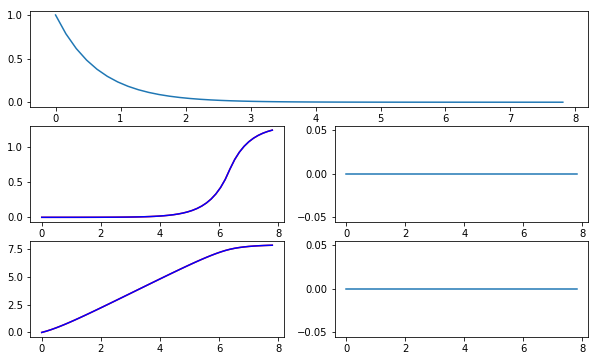

In [97]:
npts = 50
# pick covariance type
type = "ex"
if type == "se":
    cov_vv = bo.cov_vv_se
    cov_xv = bo.cov_xv_se
    cov_xx = bo.cov_xx_se
elif type == "ex":
    cov_vv = bo.cov_vv_ex
    cov_xv = bo.cov_xv_ex
    cov_xx = bo.cov_xx_ex
elif type == "re":
    cov_vv = bo.cov_vv_re
    cov_xv = bo.cov_xv_re
    cov_xx = bo.cov_xx_re
else:
    raise ValueError("Invalid covariance type.")
# plot cov_vv
tmax = runif(low = 0, high = 10, size = 1)
gamma = runif(0, tmax/10, 1)
tseq = np.linspace(start = 0, stop = tmax, num = npts)
av = np.zeros((npts, 1))
for ii in range(0,npts):
    av[ii] = cov_vv(0, tseq[ii], gamma)
plt.rcParams['figure.figsize'] = [10, 6]
plt.subplot(3,2,(1,2))
plt.plot(tseq,av)
# integrate once and compare to analytic solution
t = runif(0, tmax, 1) # first time point
s = runif(0, tmax, 1) # second time point
tseq = np.linspace(start = 0, stop = tmax, num = npts)
xv_an = np.zeros((npts,1)) # analytic solution
xv_nu = xv_an # numeric solution
for ii in range(0,npts):
    xv_an[ii] = cov_xv(tseq[ii], s, gamma)
    xv_nu[ii],err = integrate.quad(cov_vv, 0, tseq[ii], args=(s,gamma))
plt.subplot(3,2,3)
plt.plot(tseq,xv_an,'r',tseq,xv_nu,'b')
plt.subplot(3,2,4)
plt.plot(tseq,abs(xv_an-xv_nu))
# integrate twice and compare to analytic solution
xx_an = np.zeros((npts,1)) # analytic solution
xx_nu = xx_an # numeric solution
for ii in range(0,npts):
    xx_an[ii] = cov_xx(tseq[ii], s, gamma)
    xx_nu[ii],err = integrate.dblquad(cov_vv, 0, tseq[ii], 0, s, args = (gamma))
plt.subplot(3,2,5)
plt.plot(tseq,xx_an,'r',tseq,xx_nu,'b')
plt.subplot(3,2,6)
plt.plot(tseq,abs(xx_an-xx_nu))

# Updating Algorithm Test

Let $T = (t_1, \ldots, t_N)$ denote the evaluation time points, and $\XX$ and $\VV$ denote vectors of length $N$ corresponding to $x(T)$ and $v(T)$.  The solution prior is then expressed as
$$
\begin{bmatrix} \XX \\ \VV \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} \end{bmatrix} \right).
$$
Now suppose that the $N$ model interrogations $\VV_\star$ and their predictive variances $\ssi_\star^2$ are given in advance.  Then joint distribution of $(\XX, \VV, \VV_\star)$ is
$$
\begin{bmatrix} \XX \\ \VV \\ \VV_\star \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} + \diag(\ssi_\star^2) \end{bmatrix} \right),
$$
from which we can deduce calculate the mean and variance of the final update (normal) distribution, $p(\XX \mid \VV_\star)$.  This suggests the following unit test for the ODE solver:

1. Modify `ode_bayes` such that it accepts an optional input of $\VV_\star$ and $\ssi_\star^2$ (please use argument names consistent with the rest of the function).
2. Write a function to compute the mean and variance of $p(\XX \mid \VV_\star)$ based on $(\mmu_X, \mmu_V, \SSi_{XX}, \SSi_{XV}, \SSi_{VV}, \VV_
2. Run `ode_bayes` with predetermined $(\VV_\star, \ssi_\star^2)$, and check that the mean and variance output is identical to the 